# Control Experiment: Random vs Token Density Distribution

**Goal:** Test if the k-NN density power-law is emergent or just high-dimensional geometry.

**Method:**
1. Generate N random vectors uniformly distributed in d-dimensional Euclidean ball
2. Compute k-NN density vs L2 norm for random vectors
3. Load actual token data from 07.53 results
4. Compare: random (null hypothesis) vs tokens (actual data)

**Key question:** Does uniform random distribution show the same density gradient as tokens?

**Expected runtime:** ~5-10 minutes

## Configuration

In [1]:
# Random vector generation
N_RANDOM = 5000  # Number of random vectors (smaller for speed)
D_EFF = 1333     # Effective dimensionality (from participation ratio)
R_MAX = 75       # Maximum radius (matches token distribution)
RANDOM_SEED = 42

# k-NN parameters (match 07.53)
K_NEIGHBORS = 20

# Token data (from 07.53)
TOKEN_DISTANCES = '../data/vectors/distances_causal_32000_full.npy'
TOKEN_METADATA = '../data/vectors/distances_causal_32000.pt'
METRIC_TENSOR_PATH = '../data/vectors/causal_metric_tensor_qwen3_4b.pt'
MODEL_NAME = 'Qwen/Qwen3-4B-Instruct-2507'

print(f"Configuration:")
print(f"  Random vectors: {N_RANDOM:,} in {D_EFF}D ball")
print(f"  Radius: [0, {R_MAX}] logometers")
print(f"  k-NN: {K_NEIGHBORS} neighbors")

Configuration:
  Random vectors: 5,000 in 1333D ball
  Radius: [0, 75] logometers
  k-NN: 20 neighbors


## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import AutoModelForCausalLM
from scipy.spatial.distance import pdist, squareform

np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Generate Random Vectors (Uniform in Ball)

To uniformly sample in a d-dimensional ball:
1. Sample from unit Gaussian in d dimensions
2. Normalize to unit sphere
3. Scale by random radius: r ~ U(0,1)^(1/d) to get uniform volume distribution

In [3]:
print(f"\nGenerating {N_RANDOM:,} random vectors in {D_EFF}D ball...")

# Step 1: Sample from unit Gaussian
random_vectors = np.random.randn(N_RANDOM, D_EFF)

# Step 2: Normalize to unit sphere
norms = np.linalg.norm(random_vectors, axis=1, keepdims=True)
random_vectors = random_vectors / norms

# Step 3: Scale by random radii (uniform volume distribution)
# For uniform distribution in ball: r ~ U(0,1)^(1/d)
radii = np.random.uniform(0, 1, N_RANDOM) ** (1.0 / D_EFF)
radii = radii * R_MAX  # Scale to [0, R_MAX]
random_vectors = random_vectors * radii[:, np.newaxis]

# Compute L2 norms
random_norms = np.linalg.norm(random_vectors, axis=1)

print(f"✓ Generated random vectors")
print(f"\nRandom norm statistics:")
print(f"  Min: {random_norms.min():.2f}")
print(f"  Max: {random_norms.max():.2f}")
print(f"  Mean: {random_norms.mean():.2f}")
print(f"  Median: {np.median(random_norms):.2f}")
print(f"\n  (Expected median for uniform in ball: ~{R_MAX * (0.5 ** (1/D_EFF)):.2f})")


Generating 5,000 random vectors in 1333D ball...
✓ Generated random vectors

Random norm statistics:
  Min: 74.53
  Max: 75.00
  Mean: 74.94
  Median: 74.96

  (Expected median for uniform in ball: ~74.96)


## Compute Pairwise Distances (Random)

In [4]:
print(f"\nComputing pairwise Euclidean distances for {N_RANDOM:,} random vectors...")
print(f"  This will take ~1-2 minutes...\n")

# Compute condensed distance matrix
random_distances_condensed = pdist(random_vectors, metric='euclidean')

# Convert to square matrix
random_distances = squareform(random_distances_condensed)

print(f"✓ Computed distance matrix")
print(f"  Shape: {random_distances.shape}")
print(f"  Memory: {random_distances.nbytes / 1e6:.1f} MB")


Computing pairwise Euclidean distances for 5,000 random vectors...
  This will take ~1-2 minutes...

✓ Computed distance matrix
  Shape: (5000, 5000)
  Memory: 200.0 MB


print(f"\nLoading model and computing token causal norms...")

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float32,
    device_map='cpu',
)

gamma = model.lm_head.weight.data
del model

metric_data = torch.load(METRIC_TENSOR_PATH, weights_only=False)
M = metric_data['M'].to('cpu')  # Move to CPU

sampled_embeddings = gamma[token_indices]
M_gamma = sampled_embeddings @ M
token_norms = torch.sqrt((sampled_embeddings * M_gamma).sum(dim=-1)).numpy()

print(f"✓ Computed token causal norms")
print(f"\nToken norm statistics:")
print(f"  Min: {token_norms.min():.2f}")
print(f"  Max: {token_norms.max():.2f}")
print(f"  Mean: {token_norms.mean():.2f}")
print(f"  Median: {np.median(token_norms):.2f}")

In [5]:
print(f"\nComputing k-NN density (k={K_NEIGHBORS}) for random vectors...")

random_densities = np.zeros(N_RANDOM)

for i in range(N_RANDOM):
    dists_i = random_distances[i]
    
    # Find k nearest (excluding self)
    k_nearest_dists = np.partition(dists_i, K_NEIGHBORS)[:K_NEIGHBORS+1]
    k_nearest_dists = k_nearest_dists[k_nearest_dists > 0][:K_NEIGHBORS]
    
    # Density = 1 / mean distance
    mean_dist = k_nearest_dists.mean()
    random_densities[i] = 1.0 / mean_dist if mean_dist > 0 else 0

print(f"✓ Computed random k-NN densities")
print(f"\nRandom density statistics:")
print(f"  Min: {random_densities.min():.6f}")
print(f"  Max: {random_densities.max():.6f}")
print(f"  Mean: {random_densities.mean():.6f}")
print(f"  Median: {np.median(random_densities):.6f}")


Computing k-NN density (k=20) for random vectors...
✓ Computed random k-NN densities

Random density statistics:
  Min: 0.009797
  Max: 0.009894
  Mean: 0.009842
  Median: 0.009841


## Load Token Data from 07.53

In [6]:
print(f"\nLoading token data from 07.53...")

# Load distance matrix
token_distances = np.load(TOKEN_DISTANCES)
N_tokens = token_distances.shape[0]

# Load token indices
metadata = torch.load(TOKEN_METADATA, weights_only=False)
token_indices = metadata['token_indices'].numpy()

print(f"✓ Loaded token distance matrix ({N_tokens:,} tokens)")


Loading token data from 07.53...
✓ Loaded token distance matrix (32,000 tokens)


In [7]:
print(f"\nComputing k-NN density for tokens...")

token_densities = np.zeros(N_tokens)

for i in range(N_tokens):
    dists_i = token_distances[i]
    k_nearest_dists = np.partition(dists_i, K_NEIGHBORS)[:K_NEIGHBORS+1]
    k_nearest_dists = k_nearest_dists[k_nearest_dists > 0][:K_NEIGHBORS]
    
    mean_dist = k_nearest_dists.mean()
    token_densities[i] = 1.0 / mean_dist if mean_dist > 0 else 0

print(f"✓ Computed token k-NN densities")


Computing k-NN density for tokens...


/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_10943/333333029.py:10: RuntimeWarning: Mean of empty slice.
  mean_dist = k_nearest_dists.mean()
/Users/jefferyharrell/Projects/Azimuth/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


✓ Computed token k-NN densities


In [10]:
print(f"\nLoading model and computing token causal norms...")

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float32,
    device_map='cpu',
)

gamma = model.lm_head.weight.data
del model

metric_data = torch.load(METRIC_TENSOR_PATH, weights_only=False)
M = metric_data['M'].to('cpu')

sampled_embeddings = gamma[token_indices]
M_gamma = sampled_embeddings @ M
token_norms = torch.sqrt((sampled_embeddings * M_gamma).sum(dim=-1)).numpy()

print(f"✓ Computed token causal norms")
print(f"\nToken norm statistics:")
print(f"  Min: {token_norms.min():.2f}")
print(f"  Max: {token_norms.max():.2f}")
print(f"  Mean: {token_norms.mean():.2f}")
print(f"  Median: {np.median(token_norms):.2f}")


Loading model and computing token causal norms...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Computed token causal norms

Token norm statistics:
  Min: 21.45
  Max: 75.08
  Mean: 54.12
  Median: 55.26


## Comparison: Random vs Tokens

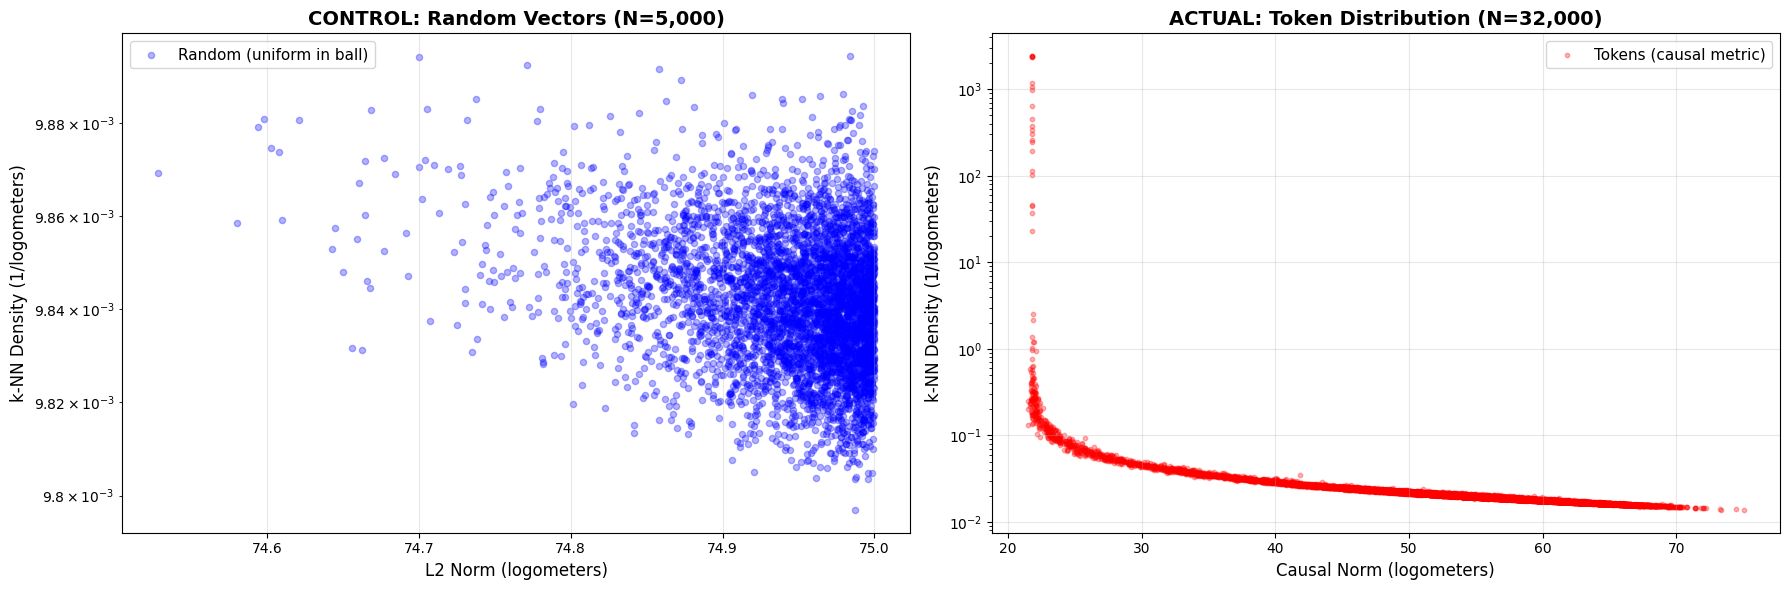


💡 Compare the two plots:
  - Random (left): What uniform distribution looks like in high-D
  - Tokens (right): Actual token distribution

  If they look SIMILAR → density gradient is just geometry
  If they look DIFFERENT → tokens have emergent structure!


In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Left: Random (control)
ax1.scatter(
    random_norms,
    random_densities,
    c='blue',
    alpha=0.3,
    s=20,
    label='Random (uniform in ball)',
    rasterized=True
)
ax1.set_xlabel('L2 Norm (logometers)', fontsize=12)
ax1.set_ylabel('k-NN Density (1/logometers)', fontsize=12)
ax1.set_yscale('log')
ax1.set_title(f'CONTROL: Random Vectors (N={N_RANDOM:,})', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.legend(fontsize=11)

# Right: Tokens (actual data)
ax2.scatter(
    token_norms,
    token_densities,
    c='red',
    alpha=0.3,
    s=10,
    label='Tokens (causal metric)',
    rasterized=True
)
ax2.set_xlabel('Causal Norm (logometers)', fontsize=12)
ax2.set_ylabel('k-NN Density (1/logometers)', fontsize=12)
ax2.set_yscale('log')
ax2.set_title(f'ACTUAL: Token Distribution (N={N_tokens:,})', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)
ax2.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("\n💡 Compare the two plots:")
print("  - Random (left): What uniform distribution looks like in high-D")
print("  - Tokens (right): Actual token distribution")
print("\n  If they look SIMILAR → density gradient is just geometry")
print("  If they look DIFFERENT → tokens have emergent structure!")

## Overlay Comparison

Both distributions on same plot for direct visual comparison.

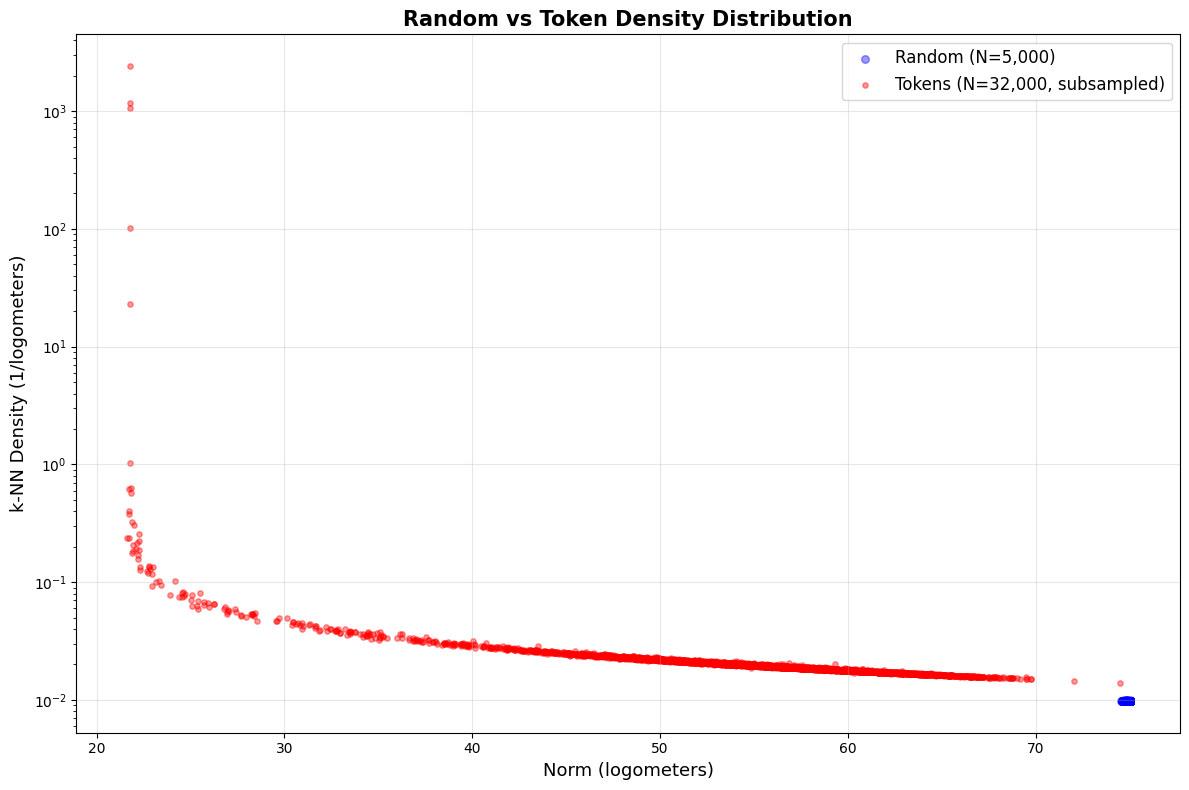


💡 Key observations:
  - Do the distributions overlap or separate?
  - Do they have the same slope (power-law exponent)?
  - Is the token core denser or sparser than random?


In [12]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot random (blue)
ax.scatter(
    random_norms,
    random_densities,
    c='blue',
    alpha=0.4,
    s=30,
    label=f'Random (N={N_RANDOM:,})',
    rasterized=True
)

# Plot tokens (red) - subsample for visibility
subsample_indices = np.random.choice(N_tokens, min(5000, N_tokens), replace=False)
ax.scatter(
    token_norms[subsample_indices],
    token_densities[subsample_indices],
    c='red',
    alpha=0.4,
    s=15,
    label=f'Tokens (N={N_tokens:,}, subsampled)',
    rasterized=True
)

ax.set_xlabel('Norm (logometers)', fontsize=13)
ax.set_ylabel('k-NN Density (1/logometers)', fontsize=13)
ax.set_yscale('log')
ax.set_title('Random vs Token Density Distribution', fontsize=15, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend(fontsize=12, loc='upper right')

plt.tight_layout()
plt.show()

print("\n💡 Key observations:")
print("  - Do the distributions overlap or separate?")
print("  - Do they have the same slope (power-law exponent)?")
print("  - Is the token core denser or sparser than random?")

## Quantitative Comparison: Core/Shell Ratios

In [13]:
print("\n" + "=" * 70)
print("QUANTITATIVE COMPARISON: Core/Shell Density Ratios")
print("=" * 70)

# Random: core = bottom 10%, shell = middle 20%
random_core_threshold = np.percentile(random_norms, 10)
random_core_mask = random_norms < random_core_threshold
random_shell_mask = (random_norms > np.percentile(random_norms, 40)) & \
                    (random_norms < np.percentile(random_norms, 60))

random_core_density = random_densities[random_core_mask].mean()
random_shell_density = random_densities[random_shell_mask].mean()
random_ratio = random_core_density / random_shell_density

print(f"\nRANDOM (uniform in ball):")
print(f"  Core density: {random_core_density:.6f}")
print(f"  Shell density: {random_shell_density:.6f}")
print(f"  Core/Shell ratio: {random_ratio:.2f}x")

# Tokens: core = bottom 10%, shell = middle 20%
token_core_threshold = np.percentile(token_norms, 10)
token_core_mask = token_norms < token_core_threshold
token_shell_mask = (token_norms > np.percentile(token_norms, 40)) & \
                   (token_norms < np.percentile(token_norms, 60))

token_core_density = token_densities[token_core_mask].mean()
token_shell_density = token_densities[token_shell_mask].mean()
token_ratio = token_core_density / token_shell_density

print(f"\nTOKENS (actual distribution):")
print(f"  Core density: {token_core_density:.6f}")
print(f"  Shell density: {token_shell_density:.6f}")
print(f"  Core/Shell ratio: {token_ratio:.2f}x")

print(f"\n" + "=" * 70)
print("INTERPRETATION:")
print("=" * 70)

if abs(random_ratio - token_ratio) / random_ratio < 0.5:
    print(f"\n⚠️  SIMILAR ratios ({random_ratio:.1f}x vs {token_ratio:.1f}x)")
    print(f"   The density gradient is mostly explained by high-D geometry")
    print(f"   Tokens don't have much emergent radial structure")
else:
    print(f"\n✅ DIFFERENT ratios ({random_ratio:.1f}x vs {token_ratio:.1f}x)")
    print(f"   Tokens have EMERGENT structure not explained by geometry alone!")
    if token_ratio > random_ratio:
        print(f"   Tokens are MORE concentrated toward core than random")
    else:
        print(f"   Tokens are MORE dispersed than random")


QUANTITATIVE COMPARISON: Core/Shell Density Ratios

RANDOM (uniform in ball):
  Core density: 0.009850
  Shell density: 0.009840
  Core/Shell ratio: 1.00x

TOKENS (actual distribution):
  Core density: 5.776583
  Shell density: 0.019574
  Core/Shell ratio: 295.12x

INTERPRETATION:

✅ DIFFERENT ratios (1.0x vs 295.1x)
   Tokens have EMERGENT structure not explained by geometry alone!
   Tokens are MORE concentrated toward core than random



Token distribution at small norms:
  r < 22: 573 tokens
  r < 25: 780 tokens
  r < 30: 1,004 tokens


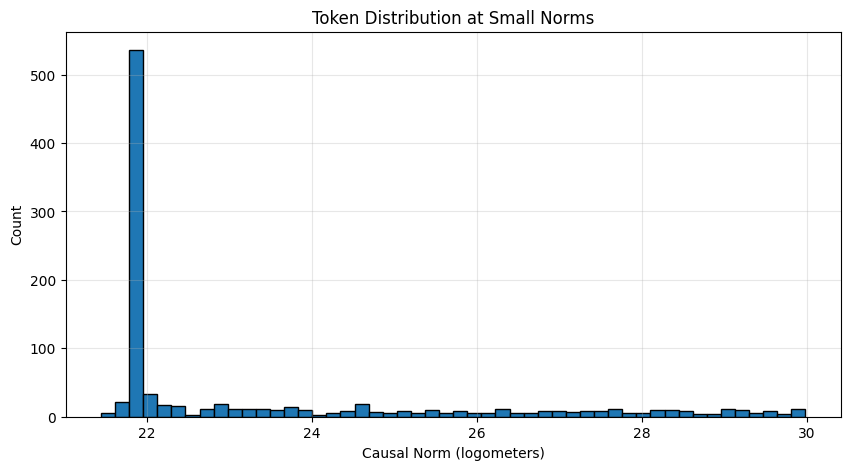

In [14]:
  # Check the distribution at small norms
  print("\nToken distribution at small norms:")
  print(f"  r < 22: {(token_norms < 22).sum():,} tokens")
  print(f"  r < 25: {(token_norms < 25).sum():,} tokens")
  print(f"  r < 30: {(token_norms < 30).sum():,} tokens")

  # Histogram at low norms
  plt.figure(figsize=(10, 5))
  plt.hist(token_norms[token_norms < 30], bins=50,
  edgecolor='black')
  plt.xlabel('Causal Norm (logometers)')
  plt.ylabel('Count')
  plt.title('Token Distribution at Small Norms')
  plt.grid(alpha=0.3)
  plt.show()

## Summary

**Question:** Is the density power-law emergent or just high-dimensional geometry?

**Method:** Compare tokens vs uniform random distribution in d=1333 ball

**Answer:** Check the plots and core/shell ratios above!

---

**Possible outcomes:**
1. **Similar distributions** → Density gradient is geometric artifact
2. **Different distributions** → Tokens have emergent clustering structure
3. **Different slopes** → Token space has different effective geometry